<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# How to RAG

by Fabian Märki

## Summary
The aim of this notebook is to illustrate how to build a RAG.

## Links
- [A Comprehensive Guide to RAG](https://www.chatbees.ai/blog/rag-nlp)
- [LangChain RAG Tutorial](https://python.langchain.com/docs/tutorials/rag/) with a [Detailed Walkthrough](https://python.langchain.com/docs/tutorials/rag/#detailed-walkthrough) (worth reading)
- [Haystack RAG Tutorial](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2024_HS_CAS_NLP_LAB_Notebooks/blob/master/10_a_How_to_RAG.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.10.0,<0.11.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.transformers import get_compute_device

import pandas as pd
import numpy as np

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [2]:
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

2024-11-10 10:24:05.728155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 10:24:05.750310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 10:24:05.756077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


OS name: posix
Platform name: Linux
Platform release: 6.8.0-47-generic
Python version: 3.11.0rc1
CPU cores: 6
RAM: 31.11GB total and 24.16GB available
Tensorflow version: 2.17.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


/usr/local/lib/python3.11/dist-packages/pynvml/smi.py:5: FutureWarning: The pynvml.smi module is deprecated and will be removed in the next release of pynvml. Please use pynvml_utils:
(e.g. `from pynvml_utils import nvidia_smi`)
  warnings.warn(


In [3]:
%%capture

!pip install transformers
!pip install accelerate
!pip install bitsandbytes
!pip install pypdf
!pip install langchain-community
!pip install langchain-ollama
!pip install langchain-huggingface
!pip install chromadb

### Document Preparation

<img src="https://drive.switch.ch/index.php/s/qSIM5OGsGrqdaOl/download" alt="RAG Indexing">
Illustration of the document ingestion pipeline.

#### Download and Load the Documents

We will do some queries on the menu of a restaurant.

In [4]:
pdf_folder = "data/pdfs"

menu_dinner = pdf_folder + "/Menu_Dinner.pdf"
menu_kids = pdf_folder + "/Menu_Kids.pdf"
menu_week_specials = pdf_folder + "/Menu_Week_Specials.pdf"

download("https://drive.switch.ch/index.php/s/lWUezzWeYUv3Vc6/download", menu_dinner)
download("https://drive.switch.ch/index.php/s/VmjVLTmvv1mgtB1/download", menu_kids)
download("https://drive.switch.ch/index.php/s/bV5n4BxkSb2JWdP/download", menu_week_specials)

There are document loaders for different formats available:
- LangChain provides a multitude of [document loaders](https://python.langchain.com/docs/integrations/document_loaders/) for different sources
- Load a single [PDF document](https://python.langchain.com/docs/how_to/document_loader_pdf/)


In [5]:
from langchain_community.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader(pdf_folder)
documents = loader.load()

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 13 0 (offset 0)
Ignoring wrong pointing object 15 0 (offset 0)
Ignoring wrong pointing object 21 0 (offset 0)


#### Split the Documents into Chunks

- LangChain's text splitters [API reference](https://python.langchain.com/api_reference/text_splitters/index.html)
- Haystack's text splitters [API reference](https://docs.haystack.deepset.ai/docs/documentsplitter)
- [Visualize](https://chunkviz.up.railway.app/) different chunking/splitting strategies
- [Mastering Text Splitting in LangChain](https://medium.com/@harsh.vardhan7695/mastering-text-splitting-in-langchain-735313216e01) 

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter()
#splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", ".", "?", "!", ":", ","], chunk_size=512, chunk_overlap=64, length_function=len)
chunks = splitter.split_documents(documents)

In [7]:
print(chunks[5])

page_content='3. GRILLED CHEESE SANDWICH
●
●
●
Description: Melted cheese between slices of buttered bread, grilled to perfection.
Allergens: Dairy, Gluten.
Suitable for Vegetarians: Yes
4. SPAGHETTI WITH MARINARA SAUCE
●
●
●
Description: Kid-friendly spaghetti noodles topped with tomato marinara sauce.
Allergens: Gluten.
Suitable for Vegetarians: Yes
5. MINI PITA PIZZA
●
●
●
Description: Small pita bread topped with tomato sauce, cheese, and favorite toppings.
Allergens: Dairy, Gluten.
Suitable for Vegetarians: Yes
Desserts:
1. MINI ICE CREAM SUNDAE
●
●
●
Description: A scoop of vanilla ice cream with chocolate sauce and rainbow sprinkles.
Allergens: Dairy.
Suitable for Vegetarians: Yes
2. FRUIT KABOBS
●
●
●
Description: Fresh fruit chunks on skewers for a fun and healthy dessert.
Allergens: None.
Suitable for Vegetarians: Yes
3. CHOCOLATE CHIP COOKIE BITES
●
●
●
Description: Bite-sized chocolate chip cookies.
Allergens: Dairy, Gluten.
Suitable for Vegetarians: Yes
4. BANANA SPLIT
●
●

<font color='red'>**Task: Try a different TextSplitter and see if it makes a difference (see above for interesting links).**</font>

In [8]:
splitter = ...

chunks = splitter.split_documents(documents)

In [9]:
print(chunks[5])

page_content='3.

GRILLED CHEESE SANDWICH
●
●
●
Description: Melted cheese between slices of buttered bread, grilled to perfection.

Allergens: Dairy, Gluten.

Suitable for Vegetarians: Yes
4.

SPAGHETTI WITH MARINARA SAUCE
●
●
●
Description: Kid-friendly spaghetti noodles topped with tomato marinara sauce.

Allergens: Gluten.

Suitable for Vegetarians: Yes
5.

MINI PITA PIZZA
●
●
●
Description: Small pita bread topped with tomato sauce, cheese, and favorite toppings.

Allergens: Dairy, Gluten.

Suitable for Vegetarians: Yes
Desserts:
1.

MINI ICE CREAM SUNDAE
●
●
●
Description: A scoop of vanilla ice cream with chocolate sauce and rainbow sprinkles.

Allergens: Dairy.

Suitable for Vegetarians: Yes
2.

FRUIT KABOBS
●
●
●
Description: Fresh fruit chunks on skewers for a fun and healthy dessert.

Allergens: None.

Suitable for Vegetarians: Yes
3.

CHOCOLATE CHIP COOKIE BITES
●
●
●
Description: Bite-sized chocolate chip cookies.

Allergens: Dairy, Gluten.

Suitable for Vegetarians: Yes
4

#### Embed the Documents (i.e. the Chunks)

Let's use [Sentence Transformers](https://www.sbert.net) (or see here [here](https://huggingface.co/sentence-transformers)) to embed our text. Models are available from [here](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) or [here](https://huggingface.co/models?library=sentence-transformers&sort=downloads).

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name_embedder = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" #"sentence-transformers/all-mpnet-base-v2"
model_kwargs_embedder = {"device": get_compute_device()}

embedder = HuggingFaceEmbeddings(model_name=model_name_embedder, model_kwargs=model_kwargs_embedder)

/usr/local/lib/python3.11/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Let's do a quick similarity check...

In [11]:
sentences = [
    "Machine learning is very interesting.",
    "I enjoy deep learning.",
    "That is a happy person.",
    "That is a happy dog.",
    "That is a very happy person.",
    "Today is a sunny day.",
    "The weather forecast for this week is mostly sunny.",
    "I like to be in my apartment.", 
    "I enjoy staying home.", 
    "The isotope 238u decays to 206pb."
]

embeddings = embedder.embed_documents(sentences)

<Axes: >

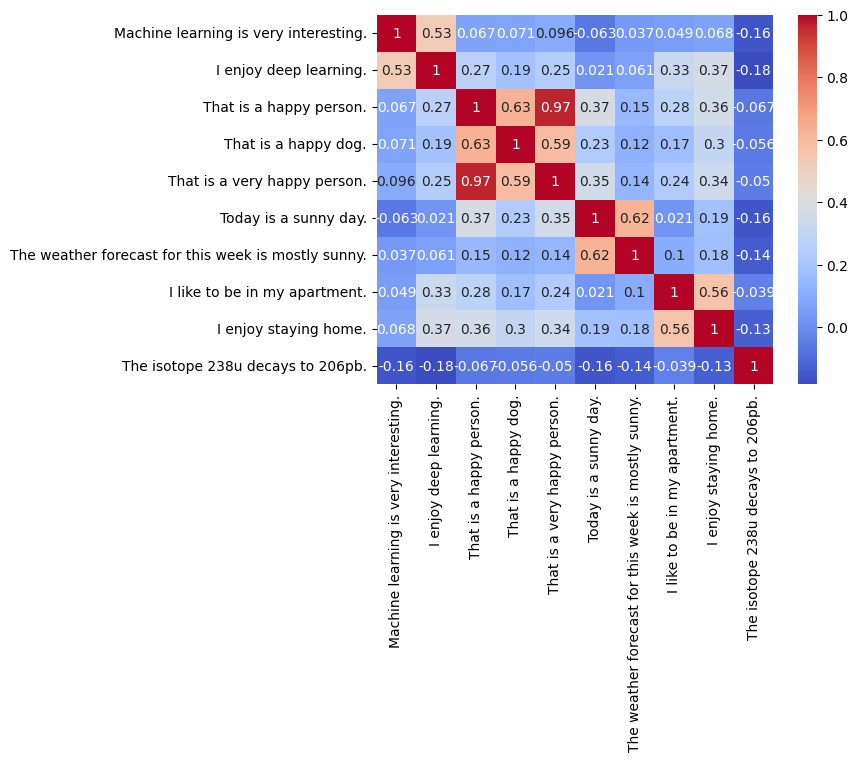

In [12]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)

sns.heatmap(cos_sim_matrix, annot=True, cmap='coolwarm', xticklabels=sentences, yticklabels=sentences)

#### Store the Embeddings/Chunks

See [here](https://python.langchain.com/docs/integrations/vectorstores/chroma/) for the detailed API of the Chroma vector store (e.g. how to add/update documents).

In [13]:
# cleanup (in case of re-execution to prevent duplicate entries)
!rm -rf chroma_db

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(documents=chunks, embedding=embedder, persist_directory="chroma_db")

# alternative without additional dependencies (but not recommended for production)
# see https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html#inmemoryvectorstore
#from langchain_core.vectorstores import InMemoryVectorStore
#vectorstore = InMemoryVectorStore(embedder)
#vectorstore.add_documents(documents=all_splits)

Let's test the retriever... see [here](https://python.langchain.com/docs/concepts/vectorstores/) for details.

In [15]:
# Maximal Marginal Relevance (MMR) attempts to diversify the results of a search to avoid returning similar and redundant documents.
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3, "fetch_k": 6})

#retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

retrieved_docs = retriever.invoke("What are the lunch specials on Tuesday?")

In [16]:
for retrieved_doc in retrieved_docs:
    print(retrieved_doc)

page_content='The Regrettable Experience – Week specials  Monday Lunch Specials • Soup of the Day: Hearty Lentil Soup (Vegetarian/Vegan)  • Salad: Grilled Chicken Caesar Salad  Allergens: Dairy (in dressing), Gluten (in croutons), Eggs (in dressing)  • Sandwich: BLT Wrap with Avocado  Allergens: Gluten (in wrap)  Tuesday Lunch Special  • Soup of the Day: Creamy Tomato Basil (Vegetarian)  Allergens: Dairy  • Salad: Strawberry Spinach Salad with Balsamic Vinaigrette  Allergens: Potential Tree Nuts (in vinaigrette)  Quiche: Broccoli and Cheddar Quiche  Allergens: Dairy, Eggs, Gluten (in crust)  Wednesday Lunch Special  • Soup of the Day: Chicken Tortilla Soup  Allergens: Dairy, Gluten (in tortilla strips)  • Salad: Greek Salad with Feta and Olives  Allergens: Dairy (in feta)  • Flatbread: Margherita Flatbread  Allergens: Dairy, Gluten  Thursday Lunch Special  • Soup of the Day: Black Bean Soup (Vegetarian/Vegan)  • Salad: Southwest Chicken Salad with Avocado Ranch  Allergens: Dairy (in dr

### Build Retrieval and Generation 

<img src="https://drive.switch.ch/index.php/s/0VUddvuY0U9e9Tj/download" alt="RAG Retrieval Generation">
Illustration of the retrieval and generation process.

Let's use Ollama...

<font color='red'>**Task: In case you run this notebook from within Google Colab you need to setup Ollama first (as showcased in `Run_LLMs_Locally_As_a_Service`).**</font>

In [17]:
import os
from langchain_ollama import ChatOllama

llm = ChatOllama(
    base_url = os.getenv('OLLAMA_SERVER_URL', "http://localhost:11434"),
    model = "llama3.2",
    temperature = 0.8,
    num_predict = 256,
    # other params ...
    #format="json"
)

Alternatively, there are also [HuggingFacePipeline](https://python.langchain.com/docs/integrations/llms/huggingface_pipelines/) and [HuggingFaceChat](https://python.langchain.com/api_reference/huggingface/chat_models/langchain_huggingface.chat_models.huggingface.ChatHuggingFace.html#langchain_huggingface.chat_models.huggingface.ChatHuggingFace) bindings which allow for accessing the LLM directly from your code... but it seems there is a [bug](https://github.com/langchain-ai/langchain/pull/25136). 

In [18]:
#import transformers
#import torch
#from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
#from langchain_core.messages import HumanMessage, SystemMessage

#model_id_llm = "NousResearch/Meta-Llama-3.1-8B-Instruct"

#pipeline = transformers.pipeline(
#    "text-generation",
#    model=model_id_llm,
#    model_kwargs={
#        "torch_dtype": torch.bfloat16,
#        "quantization_config": {"load_in_4bit": True}
#    },
#    device_map="auto",
#    max_new_tokens=256,
#    do_sample=True,
#    top_k=500, 
#    top_p=0.8,
#    temperature=0.7,
#)

#llm_pipe = HuggingFacePipeline(pipeline=pipeline)
#llm = ChatHuggingFace(llm=llm_pipe, model_id=model_id_llm)

#messages = [
#    SystemMessage(content="You are a helpful assistant."),
#    HumanMessage(content="What happens when an unstoppable force meets an immovable object?"),
#]

## see also https://www.kaggle.com/code/kingabzpro/accessing-the-llama-3-2-lightweight-models
##llm_response = llm_pipe.invoke(messages)
#llm_response = llm.invoke(messages)

#print(llm_response)

In [19]:
# Convert loaded documents into strings by concatenating their content
# and ignoring metadata
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [20]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

RAG_TEMPLATE = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

<context>
{context}
</context>

Answer the following question:

{question}"""

# Prompt Template: https://python.langchain.com/docs/concepts/prompt_templates/
rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

# LangChain Expression Language: https://python.langchain.com/docs/concepts/lcel/
chain = (
    RunnablePassthrough.assign(context=lambda input: format_docs(input["context"]))
    | rag_prompt
    | llm
    | StrOutputParser()
)

question = "What are the entrees in the children's menu?"

docs = vectorstore.similarity_search(question)

# Run
response = chain.invoke({"context": docs, "question": question})

print(response)

The entrees in the Children's Menu are:

1. Chicken Nuggets, 
2. Macaroni and Cheese,
3. Mini Cheese Quesadillas,
4. Peanut Butter and Banana Sandwich, 
5. Veggie Pita Pockets.


or directly using the chain...

In [21]:
qa_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

In [22]:
question = "What are the entrees in the children's menu?"
response = qa_chain.invoke(question)
print(response)

The entrees in the children's menu are:

1. Chicken Nuggets with ketchup or ranch dressing
2. Macaroni and Cheese
3. Mini Cheese Quesadillas
4. Peanut Butter and Banana Sandwich (with whole wheat bread)
5. Veggies Pita Pockets


In [23]:
question = "What vegetarian options are in the children's menu?"
response = qa_chain.invoke(question)
print(response)

The vegetarian options in the children's menu are Macaroni and Cheese, Mini Cheese Quesadillas, and Veggies Pita Pockets. These dishes do not contain meat or animal by-products other than dairy. They also have specific allergen warnings related to gluten and soy.


In [24]:
question = "What are the week specials for lunch specials on Monday?"
response = qa_chain.invoke(question)
print(response)

On Mondays, the lunch special options are as follows:
- Soup of the Day: Hearty Lentil Soup (Vegetarian/Vegan)
- Salad: Grilled Chicken Caesar Salad
- Sandwich: BLT Wrap with Avocado.


Let's try a different language (the model should be multimodal).

In [25]:
question = "Was sind die Wochenhits am Montag?"
response = qa_chain.invoke(question)
print(response)

Die Wochenhits am Montag sind das Lunch Special für diesen Tag: Hearty Lentil Soup (Vegetarian/Vegan) und ein Grilled Chicken Caesar Salad mit folgenden Allergen:

* Dairy (in dressing)
* Gluten (in croutons)
* Eggs (in dressing)

Das BLT Wrap mit Avocado ist auch verfügbar, aber enthält Gluten in der Wrap.


<font color='red'>**Task: Try different questions.**</font>

<font color='red'>**Task: Try to improve the RAG_TEMPLATE (the current seems to be quite generic).**</font>

## Next Steps

- Allow the llm to remember your conversation by adding a [chat history](https://python.langchain.com/docs/tutorials/qa_chat_history/)
- Allow the llm to [call tools](https://js.langchain.com/docs/how_to/tool_calling/) (e.g. to make reservations in your restaurant or [query the weather for specific locations](https://python.langchain.com/docs/tutorials/agents/))
- Allow the llm to answer questions by [retrieving information from the web](https://python.langchain.com/docs/integrations/tools/ddg/)